In [159]:
import pandas as pd
import numpy as np
import pyodbc  
from datetime import datetime 
import matplotlib.pylab as plt
from sklearn.cluster import KMeans
import seaborn as sns
import collections
import warnings
warnings.filterwarnings('ignore')
from dateutil.relativedelta import relativedelta
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
from statsmodels.tsa.stattools import adfuller # stationary or not 
from statsmodels.stats.diagnostic import acorr_ljungbox # white noise test
from statsmodels.tsa.stattools import arma_order_select_ic # AIC BIC
import statsmodels.api as sm # predict
from scipy import  stats
from statsmodels.graphics.api import qqplot
from sklearn.metrics import mean_squared_error
from math import sqrt
import itertools
from sklearn.metrics import r2_score
from statsmodels.tsa.arima_model import ARIMA
from fbprophet import Prophet
import warnings
warnings.filterwarnings('ignore')

In [160]:
# read data from data warehouse
conn = pyodbc.connect("Driver={ODBC Driver 13 for SQL Server};Server=yetidb01.database.windows.net;database=YETISQLDW01;uid=htian;PWD=HeLeNtIAn52!")
cursor = conn.cursor()

# Data Pre-processing 

#### 1) read table; make sure all orderQty>0

In [161]:
DF = pd.read_sql("SELECT S.CustomerID, C.Customer, S.OrderDate, S.Requested_Date, S.SalesOffice, S.OrderQty, P.ProductCategory, P.MasterSKU,S.sourcesystem FROM EDW_DS.ORDERFCT S  inner join [EDW_DS].[PRODUCT_DIM] P ON P.ProductID = S.ProductID  left join EDW_DS.CUSTOMER_DIM C on S.CustomerID = C.CustomerID WHERE P.ISCORE = 'TRUE' and S.SalesOffice in ('STD','HYB')  and S.RejectionReason is null and S.Ordertype Not in ('ZARF','ZARM','ZEG2','ZERF','ZERM','ZRE') and S.SoldtoParty not in ('91860','0000107894','0000114883','0000108654') and S.OrderQty>0" , conn)

#### 2) select MasterSKU you want to analysis

In [162]:
# you can add or delete MasterSKU 
select= [ 'Tank 85',
 'Tundra 35',
 'Tundra 45',
 'R10 Lowball',
 'Tundra 105',
 'Tank 45',
 'Tundra 75',
 'Tundra 350',
 'Tundra 210',
 'Tundra 65',
 'Roadie 20',
 'R26 Bottle',
 'Flip 18',
 'Hopper 30',
 'R30 Tumbler',
 'Tundra 160',
 'Hopper2.0 30',
 'R18 Bottle',
 'Tundra 110',
 'R36 Bottle',
 'R20 Tumbler',
 'Flip 8',
 'R Colsters',
 'Flip 12',
 'Tundra 125',
 'Tundra 250']

In [163]:
# only choose MasterSKU in 'select'
DF=DF[DF['MasterSKU'].isin(select)]

#### 3) replace strange Requested_Date by OrderDate (4% Requested_Date earlier than OrderDate; some Requested_Date is Null) 

In [164]:
# change datetime type, otherwise we can not choose data in specific time interval

In [165]:
DF['OrderDate'] = pd.to_datetime(DF['OrderDate']) 

In [166]:
# there are some 'nan' in DF.Requested_Date, we fill them with 0 first
DF=DF.fillna(pd.to_datetime('2010-01-01')) 

In [167]:
DF['Requested_Date'] = pd.to_datetime(DF['Requested_Date'])  

In [168]:
# 4% Requested_Date earlier than OrderDate
Date = []
for i in range(len(DF)):
    if DF.Requested_Date.iloc[i]==0:  # if the data is 0 (was 'nan' before)
        Date.append(DF.OrderDate.iloc[i])
    elif DF.OrderDate.iloc[i]>DF.Requested_Date.iloc[i]: # orderdate should be earlier than Requested_Date, these are 'strange' data
        Date.append(DF.OrderDate.iloc[i])
    else:
        Date.append(DF.Requested_Date.iloc[i])
DF['Date']=Date

#### 4) combine data to extend product history (1)Flip 12 with Flip 8/18 (Aug 2016 - June 2017) (2) R18 with R26(Mar 2016 - May 2017)

In [169]:
# Some MasterSKU launched time is not long enough, to extend the history, we combine data from similar product

In [170]:
def Extend(data, MSKU1 ,MSKU2 , begin, end):
    Copy = data[(data.MasterSKU == MSKU1) & (data.Date >= begin) & (data.Date < end)]
    Copy['MasterSKU'] = MSKU2
    data1 = pd.concat([data, Copy])
    return data1

##### Flip 8: 

In [171]:
DF1 = Extend(DF, 'Flip 12' , 'Flip 8' , '2016-08-01', '2017-07-01')

##### Flip 18: 

In [172]:
DF2 = Extend(DF1, 'Flip 12' , 'Flip 18' , '2016-08-01', '2017-07-01')    # this time, data set changed !!!

##### R26:

In [173]:
DF3 = Extend(DF2, 'R18 Bottle' , 'R26 Bottle' , '2016-03-01', '2017-05-01')

#### 5) Combine Tundra 105, 110, 125, 160, 210, 250, 350 as Large_Tundra; Hopper 30/ 2.0 30 as Hopper 30; Tank 45/85 as Tank

In [174]:
# To deal with small data size problem, we combine them as a large data set

In [175]:
def Combine(data, MSKU_set, new_name):
    data.loc[data['MasterSKU'].isin(MSKU_set), 'MasterSKU'] = new_name
    return data

##### Large_Tundra (Tundra 105, 110, 125, 160, 210, 250, 350):

In [176]:
Large_Tundra = ['Tundra 160',
'Tundra 125',
'Tundra 110',
'Tundra 250',
'Tundra 105',
'Tundra 350',
'Tundra 210']

In [177]:
DF4 = Combine(DF3, Large_Tundra, 'Large_Tundra')

##### Hopper 30 (Hopper 30/ 2.0 30) 

In [178]:
Hopper_30 = ['Hopper2.0 30', 'Hopper 30']

In [179]:
DF5 = Combine(DF4, Hopper_30, 'Hopper 30')

##### Tank (Tank 45/ 85)

In [180]:
Tank = ['Tank 45', 'Tank 85']

In [181]:
DF6 = Combine(DF5, Tank, 'Tank')

#### 6) Select Stable Standard Dealer:

Step: 1. select a time period 2. find all STD 'born' in the first year 3. check are they order at least one time every year

#### Warning:  'end' time should use the cut time[this case: '2017-05-31'] (we do not know how many stable STD remained in the future) 

In [182]:
def stable_STD(data, begin, end):
    data = data.sort_values(by=["Date"])
    data = data[(data.Date>=begin) & (data.Date<=end)]   # select the data we want to analysis
    
    years = int((end-begin).days/365)   # how many years in this interval
    remainder = (end-begin).days%365   # if the last year is not complete, how long?
    new = begin + relativedelta(years=1)  
    STD1 = data[(data.Date>=begin)&(data.Date<new)].sort_values(by=["Date"]).drop_duplicates(subset=['CustomerID'])[['CustomerID']]
                                    # pick up all STD shown in 2014
    if remainder < 0.3:    
        years-=1
    for i in range(years):  # running a loop to select 2014 STD who also shown in each remaining year
        begin = new
        new = begin + relativedelta(years=1)
        Data = data[(data.Date>=begin)&(data.Date<new)]
        STD1 = pd.merge(STD1,Data,on='CustomerID').drop_duplicates(subset=['CustomerID'])[['CustomerID']]
    data = pd.merge(data, STD1, on = 'CustomerID')[['CustomerID', 'Date', 'SalesOffice', 'OrderQty', 'ProductCategory', 'MasterSKU']]
    return STD1, data # return the stable STD and their order history

In [183]:
begin = pd.to_datetime('2014-01-01')

In [184]:
end = pd.to_datetime('2018-05-31')   # right now it is '2018-05-31', it should be '2017-05-31'

In [185]:
result = stable_STD(DF6, begin, end)

In [186]:
stable_STD = result[0]      # customerid of stable STD

In [187]:
data = result[1]       # Order history of stable STD

# Segment 

### Segment Method One: by all products 

In [188]:
# the first segment method is by average order quantity. Overall order quantity / time they appear

In [189]:
def remove_duplicates(lst):
        return list(collections.OrderedDict(zip(lst, lst)).values())

In [190]:
# after k-means clustering, the class name is not ordered by number size.(Class L=2, M=1, S=0)To change it, we use this function.
def ChangeLabel(res):
    df=res[0]
    cla=res[1]
    num = []
    n=len(cla)-1
    for item in cla:
        num.append(len(df[df.Class==item]))
    for i in range(len(num)):
        if i !=0:
            num[i]+=num[i-1]
    for i in range(len(num)):
        if i == 0:
            df.Class[:num[i]]=[n]*len(df.Class[:num[i]])
            
        else:
            df.Class[num[i-1]:num[i]] = [n]*len(df.Class[num[i-1]:num[i]])
        n-=1
    return df

In [191]:
# this function below only for k=3

In [192]:
def Overall_Segment(DF):
    
    # calculate age of each STD
    
    age = DF[['CustomerID','Date']].sort_values(by=["Date"])
    age = age.drop_duplicates(subset='CustomerID')
    age2=age.copy()
    o=[str(x.year)+'-'+str(x.month) for x in age2.Date]
    age2.Date=[datetime.strptime(x,'%Y-%m')for x in o] 
    end = pd.to_datetime(['2018-05-31']*len(age))           # we only can use the information in training data
    age2['end']=end
    live = ((age2.end-age2.Date) / np.timedelta64(1, 'M')).astype(int)
    age2['age']=live+1
    
    # use Overall quantity divided by age to get average order quantity
    
    Qty=DF['OrderQty'].groupby(DF['CustomerID']).sum().to_frame(name='overall_Qty').reset_index()
    Qty = Qty.merge(age2[['CustomerID','age']],left_on='CustomerID', right_on='CustomerID',how='inner')
    Qty['avg_Qty'] = Qty['overall_Qty']/Qty['age']
    Qty = Qty.sort_values(by=["avg_Qty"],ascending=False)

    # K means clustering:
    # 1) cluster STD into 2 groups
    # 2) redo cluster in the large group 
    
    X = np.array(Qty.avg_Qty.iloc[1:].reshape(-1,1))
    kmeans = KMeans(n_clusters = 2, random_state=0).fit(X)
    kmeans.labels_
    Class=[]
    Class.append(kmeans.labels_[0])
    Class+=list(kmeans.labels_)
    Qty["Class"] = Class
    ChangeLabel([Qty,remove_duplicates(kmeans.labels_)])
    L=len(Qty[Qty.Class==1])
    X1 = np.array(Qty.avg_Qty[L:].reshape(-1,1))
    kmeans1 = KMeans(n_clusters = 2, random_state=0).fit(X1)
    kmeans1.labels_
    M=len(kmeans1.labels_[kmeans1.labels_==1])
    Qty.Class[L:L+M]=2
    ChangeLabel([Qty,[1,2,0]])      # if number of cluster changed, this part must be changed
    return Qty
       

In [193]:
Segment = Overall_Segment(data)[['CustomerID','Class']]
seg = pd.merge(data, Segment, on = 'CustomerID', how='left')

### Segment Method Two: by Product Category 

In [194]:
# We found some STD do not order all product category. It is wrong if we use overall order quantity result to segment because 
# when we modeling, we only consider order history for one MasterSKU.
# E.g. one STD only order Drinkware, if we only use drinkware order quantity, it will in Class L, but if we use all order 
# quantity, this STD may in Class S. When we modeling drinkware, this segment will affect the result.

In [195]:
# this function below only for k=3

In [196]:
def PC_Segment(DF,PC):
    HC=DF[DF['ProductCategory']==PC]
    age = HC[['CustomerID','Date']].sort_values(by=["Date"])
    age = age.drop_duplicates(subset='CustomerID')
    age2=age.copy()
    o=[str(x.year)+'-'+str(x.month) for x in age2.Date]
    age2.Date=[datetime.strptime(x,'%Y-%m')for x in o] 
    end = pd.to_datetime(['2018-05-31']*len(age))
    age2['end']=end
    live = ((age2.end-age2.Date) / np.timedelta64(1, 'M')).astype(int)
    age2['age']=live+1
    Qty=HC.groupby(['CustomerID'])['OrderQty'].sum().to_frame(name='overall_Qty').reset_index()
    Qty = Qty.merge(age2[['CustomerID','age']],left_on='CustomerID', right_on='CustomerID',how='inner')
    Qty['avg_Qty'] = Qty['overall_Qty']/Qty['age']
    Qty = Qty.sort_values(by=["avg_Qty"],ascending=False)
    X = np.array(Qty.avg_Qty.iloc[1:].reshape(-1,1))
    kmeans = KMeans(n_clusters = 2, random_state=0).fit(X)
    kmeans.labels_
    Class=[]
    Class.append(kmeans.labels_[0])
    Class+=list(kmeans.labels_)
    Qty["Class"] = Class
    ChangeLabel([Qty,remove_duplicates(kmeans.labels_)])
    L=len(Qty[Qty.Class==1])
    X1 = np.array(Qty.avg_Qty[L:].reshape(-1,1))
    kmeans1 = KMeans(n_clusters = 2, random_state=0).fit(X1)
    kmeans1.labels_
    M=len(kmeans1.labels_[kmeans1.labels_==1])
    Qty.Class[L:L+M]=2
    ChangeLabel([Qty,[1,2,0]])
    return Qty

In [197]:
SC_Class = PC_Segment(data,'Soft Cooler')[['CustomerID','Class']]
SC_seg = pd.merge(data, SC_Class, on = 'CustomerID')

In [198]:
DW_Class = PC_Segment(data,'Drinkware')[['CustomerID','Class']]
DW_seg = pd.merge(data, DW_Class, on = 'CustomerID')

In [199]:
HC_Class = PC_Segment(data,'Hard Cooler')[['CustomerID','Class']]
HC_seg = pd.merge(data, HC_Class, on = 'CustomerID')

### Check the correlation between Class size and order quantity 

##### Correlation (OrderQty for each class in each month , Class size)

In [200]:
# only for overall Quantity segment result check

In [201]:
def corr_overallQty(dat):
    
    o=[str(x.year)+'-'+str(x.month) for x in dat.Date]
    dat.Date=[datetime.strptime(x,'%Y-%m')for x in o] 
    
    dfO1 = dat.groupby(['Class','Date'])['OrderQty'].mean().to_frame(name = 'OrderQty').reset_index()
    print ('Correlation between overall quantity and class size: ')
    print(dfO1.corr())
    print()
    
    dfD = dat[dat.ProductCategory=='Drinkware']
    dfD1 = dfD.groupby(['Class','Date'])['OrderQty'].mean().to_frame(name = 'DW_Qty').reset_index()
    print ('Correlation between Drinkware order quantity and class size: ')
    print(dfD1.corr())
    print()
    
    dfH = dat[dat.ProductCategory=='Hard Cooler']
    dfH1 = dfH.groupby(['Class','Date'])['OrderQty'].mean().to_frame(name = 'HC_Qty').reset_index()
    print ('Correlation between Hard Cooler order quantity and class size: ')
    print(dfH1.corr())
    print()
    
    dfS = dat[dat.ProductCategory=='Soft Cooler']
    dfS1 = dfS.groupby(['Class','Date'])['OrderQty'].mean().to_frame(name = 'SC_Qty').reset_index()
    print ('Correlation between Soft Cooler order quantity and class size: ')
    print(dfS1.corr())
    

In [202]:
# only for drinkware segment result check

In [203]:
def corr_drinkware(dat):
    
    o=[str(x.year)+'-'+str(x.month) for x in dat.Date]
    dat.Date=[datetime.strptime(x,'%Y-%m')for x in o] 
    
    dfD = dat[dat.ProductCategory=='Drinkware']
    dfD1 = dfD.groupby(['Class','Date'])['OrderQty'].mean().to_frame(name = 'DW_Qty').reset_index()
    print ('Correlation between Drinkware order quantity and class size: ')
    print(dfD1.corr())


In [204]:
# only for Hard Cooler segment result check

In [205]:
def corr_hardcooler(dat):
    
    o=[str(x.year)+'-'+str(x.month) for x in dat.Date]
    dat.Date=[datetime.strptime(x,'%Y-%m')for x in o] 
    
    dfH = dat[dat.ProductCategory=='Hard Cooler']
    dfH1 = dfH.groupby(['Class','Date'])['OrderQty'].mean().to_frame(name = 'HC_Qty').reset_index()
    print ('Correlation between Hard Cooler order quantity and class size: ')
    print(dfH1.corr())


In [206]:
# only forSoft Cooler segment result check

In [207]:
def corr_softcooler(dat):
    
    o=[str(x.year)+'-'+str(x.month) for x in dat.Date]
    dat.Date=[datetime.strptime(x,'%Y-%m')for x in o] 
    
    dfS = dat[dat.ProductCategory=='Soft Cooler']
    dfS1 = dfS.groupby(['Class','Date'])['OrderQty'].mean().to_frame(name = 'SC_Qty').reset_index()
    print ('Correlation between Soft Cooler order quantity and class size: ')
    print(dfS1.corr())

In [208]:
corr_overallQty(seg)   # only for overall quantity segment method correlation check

Correlation between overall quantity and class size: 
             Class  OrderQty
Class     1.000000  0.523448
OrderQty  0.523448  1.000000

Correlation between Drinkware order quantity and class size: 
           Class    DW_Qty
Class   1.000000  0.489518
DW_Qty  0.489518  1.000000

Correlation between Hard Cooler order quantity and class size: 
           Class    HC_Qty
Class   1.000000  0.676485
HC_Qty  0.676485  1.000000

Correlation between Soft Cooler order quantity and class size: 
          Class   SC_Qty
Class   1.00000  0.64748
SC_Qty  0.64748  1.00000


In [209]:
corr_drinkware(DW_seg)

Correlation between Drinkware order quantity and class size: 
           Class    DW_Qty
Class   1.000000  0.531947
DW_Qty  0.531947  1.000000


In [210]:
corr_hardcooler(HC_seg)

Correlation between Hard Cooler order quantity and class size: 
           Class    HC_Qty
Class   1.000000  0.681325
HC_Qty  0.681325  1.000000


In [211]:
corr_softcooler(SC_seg)

Correlation between Soft Cooler order quantity and class size: 
           Class    SC_Qty
Class   1.000000  0.638971
SC_Qty  0.638971  1.000000


# Time series Modeling

### a)  Data select 

In [54]:
# We want to preduct each MasterSKU monthly. But time series need data not less than 40. If we need one more year as testing 
# data, this number will increase to 52. According to start time of most MasterSKU, the data is not enough. So we predict weekly 

#####################

 Monthly

#####################

In [55]:
# function below output the training and testing data with the form that time series models need

In [212]:
# transfer datetime to month by change the date to the first day if that month. E.g '2017-03-XX' to '2017-03-01'

def day2month(data):
    data.copy()
    o=[str(x.year)+'-'+str(x.month) for x in data.Date]
    data.Date=[datetime.strptime(x,'%Y-%m')for x in o] 
    return data

In [213]:
# select specific MasterSKU

def select_Monthly(data, cut, MasterSKU, Class):
    data1 = data[(data.MasterSKU==MasterSKU)&(data.Class==Class)]
    df = day2month(data1[(data1.Date<=cut)])
    dft = day2month(data1[(data1.Date>cut)])
    
    DW1=df.groupby('Date')['OrderQty'].sum()
    DW1=DW1.to_frame(name = 'DW').reset_index()
    DW1=DW1.set_index(DW1.Date)
    dw=DW1['DW'].astype(float)
    
    DWT=dft.groupby('Date')['OrderQty'].sum()
    DWT=DWT.to_frame(name = 'DW').reset_index()
    DWT=DWT.set_index(DWT.Date)
    dwt=DWT['DW'].astype(float)
    
    return (dw,dwt)

#####################

Weekly

#####################

In [215]:
def select_Weekly(data, Begin, cut, MasterSKU, Class):
    data1 = data[(data.Date>=Begin)&(data.MasterSKU==MasterSKU)&(data.Class==Class)]
    df = data1[(data1.Date<=cut)]
    dft = data1[(data1.Date>cut)]
    
    DW1=df[['Date','OrderQty']].reset_index().set_index(df.Date).OrderQty.astype(float).to_period('W')
    DW2=DW1.to_frame(name = 'OrderQty')
    DW2=DW2.groupby('Date')['OrderQty'].sum().to_frame(name = 'OrderQty').reset_index()
    DW2=DW2.set_index(DW2.Date)
    dw=DW2['OrderQty'].astype(float)
    
    DWT1=dft[['Date','OrderQty']].reset_index().set_index(dft.Date).OrderQty.astype(float).to_period('W')
    DWT2=DWT1.to_frame(name = 'OrderQty')
    DWT2=DWT2.groupby('Date')['OrderQty'].sum().to_frame(name = 'OrderQty').reset_index()
    DWT2=DWT2.set_index(DWT2.Date)
    dwt=DWT2['OrderQty'].astype(float)
    
    return (dw,dwt)

### b) Data check and fill nan 

In [216]:
def fill0(data,time):
    for date in time:
        if date not in data.index.values:
            data.loc[date] = 0
    data = data.sort_index()
    return data

In [217]:
# check missing data in time series, if yes, using 0 to fill

def check_Monthly(data,result,cut):
    TRA=select_Monthly(data, cut, 'Roadie 20', 0)[0].index.values  
    TES=select_Monthly(data, cut, 'Roadie 20', 0)[1].index.values # use Roadie 20 as Reference 
                                                          # because Roadie 20 have enough data (no missing value)
    if len(result[0])<len(TRA):
        R1=fill0(result[0],TRA)
    else:
        R1=result[0]
    if len(result[1])<len(TES):
        R2=fill0(result[1],TES)
    else:
        R2=result[1]
    return (R1,R2)

In [218]:
# Most masterSKU in each class do not have order every week, we need to fill the order quantity with 0 in these week

In [219]:
# check missing data in time series, if yes, using 0 to fill

def check_Weekly(data, result, begin, cut):
    TRA=select_Weekly(data, begin, cut, 'Roadie 20', 0)[0].index.values  
    TES=select_Weekly(data, begin, cut, 'Roadie 20', 0)[1].index.values # use Roadie 20 as Reference 
                                                          # because Roadie 20 have enough data (no missing value)
    if len(result[0])<len(TRA):
        R1=fill0(result[0],TRA)
    else:
        R1=result[0]
    if len(result[1])<len(TES):
        R2=fill0(result[1],TES)
    else:
        R2=result[1]
    return (R1,R2)

In [220]:
# this function help you know which mastersku has missing value

def testing_Monthly(data, MSKU_set, Class_number, cut):
    
    TRA=select_Monthly(data, cut, 'Roadie 20', 0)[0].index.values  
    TES=select_Monthly(data, cut, 'Roadie 20', 0)[1].index.values
    
    for item in MSKU_set:
        for i in range(Class_number):
            res=select_Monthly(data, cut, item, i)
            if len(res[0])<len(TRA):
                print(item, i, 'train', len(res[0]))
            if len(res[1])<len(TES):
                print(item, i, 'test',len(res[1]))
    

In [221]:
# this function help you know which mastersku has missing value

def testing_Weekly (data, Set, Class_number, cut):
    
    for item in list(Set.keys()):
        begin=Set[item]
        TRA=select_Weekly(data, begin, cut, 'Roadie 20', 0)[0].index.values  
        TES=select_Weekly(data, begin, cut, 'Roadie 20', 0)[1].index.values
        
        for i in range(Class_number):
            res=select_Weekly(data, begin, cut, item, i)
            if len(res[0])<len(TRA):
                print(item, i, 'train', len(res[0]))
            if len(res[1])<len(TES):
                print(item, i, 'test',len(res[1]))
 

In [222]:
# these are the MasterSKU we need to predict monthly

In [223]:
aim=['Tundra 45', 'Tank', 'Roadie 20', 'Large_Tundra','Tundra 65','Tundra 35']

In [224]:
testing_Monthly (seg, aim, 3, '2017-5-31')

Tank 2 train 31


In [225]:
# these are the MasterSKU we need to predict weekly and their start time

In [226]:
Weekly = {'Tundra 75': '2014-03-01', 'Hopper 30':'2015-02-01', 'R30 Tumbler':'2014-04-01', 'R20 Tumbler':'2014-04-01', 
          'R Colsters': '2015-02-01', 'R10 Lowball':'2015-09-01', 'R36 Bottle':'2016-03-01','R18 Bottle':'2016-03-01',
          'R26 Bottle':'2016-03-01', 'Flip 18':'2016-08-01', 'Flip 8':'2016-08-01', 'Flip 12':'2016-08-01'}

In [227]:
testing_Weekly (seg,  Weekly, 3, '2017-5-31')

### c) data explore 

In [77]:
# this function shows the basic information of time series, it may help you determine which order value(p,d,q,P,D,Q,S) to choose

In [228]:
def basic_Monthly(data):
    fig = plt.figure(figsize=(12, 8))
    plt.plot(data,color='gray',linestyle='--',marker='o')
    plt.grid()
    
    print("######################") 
    noiseRes = acorr_ljungbox(data, lags=1)
    print ('result of white noice testing (p-value should be small, otherwise: No information in this dataset)')
    print ('stat                  | p-value')
    for x in noiseRes:
        print (x,'|',)
        
    print("######################")   
    
    def test_stationarity(timeseries):

        #Determing rolling statistics
        rolmean = pd.rolling_mean(timeseries, window=12)
        rolstd = pd.rolling_std(timeseries, window=12)

        #Plot rolling statistics:
        fig = plt.figure(figsize=(12, 8))
        orig = plt.plot(timeseries, color='blue',label='Original')
        mean = plt.plot(rolmean, color='red', label='Rolling Mean')
        std = plt.plot(rolstd, color='black', label = 'Rolling Std')
        plt.legend(loc='best')
        plt.title('Rolling Mean & Standard Deviation')
        plt.show()
    
        #Perform Dickey-Fuller test:
        print ('Results of Dickey-Fuller Test:')
        dftest = adfuller(timeseries, autolag='AIC')
        dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
        for key,value in dftest[4].items():
            dfoutput['Critical Value (%s)'%key] = value
        print (dfoutput) 
    
    test_stationarity(data)
    
    print("######################") 
   
    if len(data)>60:
        plot_acf(data[:60]).show()  # acf
        plot_pacf(data[:60]).show() # pacf
    else:
        plot_acf(data).show() 
        plot_pacf(data).show() 
    
    

In [229]:
def basic_Weekly(data):
    fig = plt.figure(figsize=(12, 8))
    plt.plot(list(data),color='gray',linestyle='--',marker='o')
    plt.grid()
    
    print("######################") 
    noiseRes = acorr_ljungbox(data, lags=1)
    print ('result of white noice testing (p-value should be small, otherwise: No information in this dataset)')
    print ('stat                  | p-value')
    for x in noiseRes:
        print (x,'|',)
        
    print("######################")   
    
    def test_stationarity(timeseries):

        #Determing rolling statistics
        rolmean = pd.rolling_mean(timeseries, window=12)
        rolstd = pd.rolling_std(timeseries, window=12)

        #Plot rolling statistics:
        fig = plt.figure(figsize=(12, 8))
        orig = plt.plot(list(timeseries), color='blue',label='Original')
        mean = plt.plot(list(rolmean), color='red', label='Rolling Mean')
        std = plt.plot(list(rolstd), color='black', label = 'Rolling Std')
        plt.legend(loc='best')
        plt.title('Rolling Mean & Standard Deviation')
        plt.show()
    
        #Perform Dickey-Fuller test:
        print ('Results of Dickey-Fuller Test:')
        dftest = adfuller(timeseries, autolag='AIC')
        dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
        for key,value in dftest[4].items():
            dfoutput['Critical Value (%s)'%key] = value
        print (dfoutput) 
    
    test_stationarity(data)
    
    print("######################") 
    # acf
    plot_acf(data[:50]).show() 
   
    
    #pacf
    plot_pacf(data[:50]).show() 
   

### d) ARIMA 

#### Order value select (there are 3 order values in ARIMA: p,d,q) 

In [230]:
# We can not only the function above to determine which order value to use. We also need to test all combination of order value.

In [257]:
def arima(maxorder,diff, data,test): # diff is a list contains all possible diff
    p = q = range(0, maxorder) 
    d = diff
    pdq = list(itertools.product(p, d, q)) # Generate all different combinations of p, q and q triplets
    res=pd.DataFrame(columns=['Param','Smape','mse','AIC','BIC'])
    
    for param in pdq:
        try:
            mod = ARIMA(data.values,param)                                 
            results = mod.fit()
                
            
            # predict and add test to compare
            predicts = results.forecast(steps=len(test))[0]
            
            rms = sqrt(mean_squared_error(test, predicts))
            
            comp = pd.DataFrame()
            comp['original'] = test
            comp['predict'] = predicts
            q1=(abs(comp['original']-comp['predict'])/((comp['original']+comp['predict'])/2))*100
            Smape=np.mean(abs(q1))
            
            res=res.append({'Param':param,'Smape':Smape, 'mse':rms,'AIC':results.aic,'BIC':results.bic}, ignore_index=True)
          #  print (param,results.aic,results.bic,rms)
        except:
            continue
    res0 = res.sort_values(by=['Smape']).reset_index()['Smape'][0]        
    res1 = res.sort_values(by=["mse"]).reset_index()['Smape'][0]
    para0 = res.sort_values(by=['Smape']).reset_index()['Param'][0]  
    para1 = res.sort_values(by=['mse']).reset_index()['Param'][0]
    return (res0,res1,para0,para1)


#### Output the best result from ARIMA 

In [232]:
def ARIMA_modeling(data,order,test): 
    tempModel = ARIMA(data.values,order).fit() # fit the value into model
    
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(111)
    print("QQ plot of residuals (should be like a straight line)")
    fig = qqplot(tempModel.resid, line='q', ax=ax, fit=True)
    print("######################")
    noiseRes = acorr_ljungbox(tempModel.resid, lags=1)
    print ("result of residual's white noice testing (should be very large)")
    print ('stat                  | p-value')
    for x in noiseRes:
        print (x,'|',)
    print("######################")
    predicts = tempModel.forecast(steps=len(test))[0]
    pred_CI = tempModel.forecast(steps=len(test))[2]
    low,high = [],[]
    for i in range(len(pred_CI)):
        low.append(pred_CI[i][0])
        high.append(pred_CI[i][1])
        
        
    comp = pd.DataFrame()
    comp['original'] = test
    comp['predict'] = predicts
    comp['low'] = low
    comp['high'] = high
    comp.plot()
    
    print("######################")
    rms = sqrt(mean_squared_error(test, predicts))
    print('mean squared error: ', rms)
    print("######################")
    
#    comp = comp[comp.original!=0]
    q=(abs(comp['original']-comp['predict'])/comp['original'])*100
    print(q)
    print('average MAPE: ',np.mean(abs(q)), '%')
    print('If MAPE is "Inf", it because the test data contains 0')
    print("######################")
    q1=(abs(comp['original']-comp['predict'])/((comp['original']+comp['predict'])/2))*100
    print(q1)
    print('average Symmetric MAPE: ',np.mean(abs(q1)), '%')

### e) Seasonal ARIMA

#### Order value select (there are 7 order values in SARIMA: p,d,q, P,D,Q,S) 

In [233]:
def sarima(maxorder,diff,seasonal,data,test):
    p = q = range(0, maxorder) 
    d = diff
    pdq = list(itertools.product(p, d, q)) # Generate all different combinations of p, q and q triplets
    

    res=pd.DataFrame(columns=['Param','Seasonal_param','Smape','mse','AIC','BIC'])
    
    for season in seasonal:
        pdq_x_PDQs = [(x[0], x[1], x[2], season) for x in list(itertools.product(p, d, q))] # Generate all different combinations of seasonal p, q and q triplets
    
    
        for param in pdq:
            for seasonal_param in pdq_x_PDQs:
                try:
                    mod = sm.tsa.statespace.SARIMAX(data.values,
                                                    order=param,
                                                    seasonal_order=seasonal_param,
                                                    enforce_stationarity=False,
                                                    enforce_invertibility=False)
                    results = mod.fit()  
                
            
                   # predict and add test to compare
                    predicts = results.forecast(steps=len(test))
                    rms= sqrt(mean_squared_error(test, predicts))
          
                    comp = pd.DataFrame()
                    comp['original'] = test
                    comp['predict'] = predicts
                    q1=(abs(comp['original']-comp['predict'])/((comp['original']+comp['predict'])/2))*100
                    Smape=np.mean(abs(q1))
        
                    res=res.append({'Param':param,'Seasonal_param':seasonal_param,'Smape':Smape, 'mse':rms,'AIC':results.aic,'BIC':results.bic}, ignore_index=True)
                    
                    
                except:
                    continue
    
    res0 = res.sort_values(by=['Smape'])[:2]        
    res1 = res.sort_values(by=["mse"])[:2]
    res2 = res.sort_values(by=["AIC"])[:2]
    res3 = res.sort_values(by=["BIC"])[:2]
    print(res0)
    print(res1)
    print(res2)
    print(res3)

#### Output the best result from SARIMA 

In [234]:
def SARIMA_modeling(data,order,seasonal_order,test): 
    mod = sm.tsa.statespace.SARIMAX(data.values, 
                                  #  exog=exog.values,
                                order=order, 
                                seasonal_order=seasonal_order,   
                                enforce_stationarity=False,
                                enforce_invertibility=False)
    results = mod.fit()
    print(results.summary())
    print("######################")
    pred = results.forecast(steps=len(test))
    comp = pd.DataFrame()
    comp['original'] = test
    comp['predict'] = pred
    comp.plot()
    print("######################")
    rms = sqrt(mean_squared_error(test, pred))
    print('mean squared error: ', rms)
    print("######################")
    noiseRes = acorr_ljungbox(results.resid, lags=1)
    print ("result of residual's white noice testing (should be very large)")
    print ('stat                  | p-value')
    for x in noiseRes:
        print (x,'|',)
    print("######################")
    print('residuals')
    results.plot_diagnostics(figsize=(15, 12))
    plt.show()
    print("######################")
    q=(abs(comp['original']-comp['predict'])/comp['original'])*100
    print(q)
    print('average MAPE: ',np.mean(abs(q)), '%')
    print('If MAPE is "Inf", it because the test data contains 0')
    print("######################")
    q1=(abs(comp['original']-comp['predict'])/((comp['original']+comp['predict'])/2))*100
    print(q1)
    print('average Symmetric: ',np.mean(abs(q1)), '%')

### f) Baseline: Prophet & Naive Model

In [235]:
# output the predict result using Facebook package-Prophet

In [236]:
def prophet_Weekly(train,test):
    X = pd.DataFrame(index=range(0,len(train)))
    c=[]
    for item in train.index:
        c.append(str(item).split('/')[0])
    X['ds'] = c
    X['y'] = train.values
    m = Prophet()
    m.fit(X)
    future_data = m.make_future_dataframe(periods=len(test), freq = 'w')
    forecast_data = m.predict(future_data)
    m.plot(forecast_data)
    predict=list(forecast_data['yhat'][-len(test):])
    original=list(test)
    comp = pd.DataFrame()
    comp['original'] = original
    comp['predict'] = predict
    comp.plot()
    print("######################")
    q=(abs(comp['original']-comp['predict'])/comp['original'])*100
    print(q)
    print('average MAPE: ',np.mean(abs(q)), '%')
    print('If MAPE is "Inf", it because the test data contains 0')
    print("######################")
    q1=(abs(comp['original']-comp['predict'])/((comp['original']+comp['predict'])/2))*100
    print(q1)
    print('average Symmetric MAPE: ',np.mean(abs(q1)), '%')

In [237]:
def prophet_Monthly(train,test):
    X = pd.DataFrame(index=range(0,len(train)))
    X['ds'] = train.index
    X['y'] = train.values
    m = Prophet()
    m.fit(X)
    future_data = m.make_future_dataframe(periods=len(test), freq = 'm')
    forecast_data = m.predict(future_data)
    m.plot(forecast_data)
    predict=list(forecast_data['yhat'][-len(test):])
    original=list(test)
    comp = pd.DataFrame()
    comp['original'] = original
    comp['predict'] = predict
    comp.plot()
    print("######################")
    q=(abs(comp['original']-comp['predict'])/comp['original'])*100
    print(q)
    print('average MAPE: ',np.mean(abs(q)), '%')
    print('If MAPE is "Inf", it because the test data contains 0')
    print("######################")
    q1=(abs(comp['original']-comp['predict'])/((comp['original']+comp['predict'])/2))*100
    print(q1)
    print('average Symmetric MAPE: ',np.mean(abs(q1)), '%')

In [238]:
# use the average of 12 training data as the first predict result then, use average of this predict result and 11 training 
# data as the second predict result 

In [239]:
def Naive(train,test):
    data=list(train[-len(test):])
    r=[]
    for i in range(len(data)):
        r.append(np.mean(data[i:]+r))
    original=list(test)
    comp = pd.DataFrame()
    comp['original'] = original
    comp['predict'] = r
    comp.plot()
    print("######################")
    q=(abs(comp['original']-comp['predict'])/comp['original'])*100
    print(q)
    print('average MAPE: ',np.mean(abs(q)), '%')
    print('If MAPE is "Inf", the test data contains 0')
    print("######################")
    q1=(abs(comp['original']-comp['predict'])/((comp['original']+comp['predict'])/2))*100
    print(q1)
    print('average Symmetric MAPE: ',np.mean(abs(q1)), '%')

### g) example: Tundra 45, Class L (Monthly); Tundra 75, Class S(Weekly)

In [240]:
HC_Class = PC_Segment(data,'Hard Cooler')[['CustomerID','Class']]
HC_seg = pd.merge(data, HC_Class, on = 'CustomerID')

##### Tundra 45, Class L 

In [242]:
result=check_Monthly(HC_seg,select_Monthly(HC_seg, '2017-05-31', 'Roadie 20', 0),'2017-5-31')

In [243]:
tra,tes = result[0],result[1]

In [254]:
arima(10,[0,1,2], tra,tes)    # ARIMA

81.4432125703263
         Param      Smape        mse          AIC          BIC
105  (9, 1, 3)  36.068175  29.976446  2133.173696  2177.074874
27   (2, 1, 0)  36.860424  30.215511  2167.401326  2179.944520
        Param      Smape        mse          AIC          BIC
37  (3, 1, 1)  66.330788  42.684183  2125.025172  2143.839962
11  (0, 1, 1)  52.672210  37.776896  2125.098214  2134.505610
        Param      Smape        mse          AIC          BIC
11  (0, 1, 1)  52.672210  37.776896  2125.098214  2134.505610
12  (0, 1, 2)  52.534698  37.721931  2127.097224  2139.640417


In [156]:
sarima(3, [0,1,2], range(0,13),tra,tes)   # SARIMA

         Param Seasonal_param      Smape         mse         AIC         BIC
293  (0, 0, 2)   (0, 0, 2, 1)  30.702993  323.874958  883.071176  892.922635
19   (0, 0, 2)   (0, 0, 2, 0)  30.702993  323.874958  883.071176  892.922635
          Param Seasonal_param       Smape         mse         AIC         BIC
4850  (1, 1, 0)   (1, 2, 0, 7)   53.133374  170.483060  552.187259  558.098135
3998  (0, 2, 0)   (0, 1, 1, 6)  102.820924  179.959985  718.667985  722.608568
          Param Seasonal_param       Smape          mse        AIC        BIC
7466  (2, 2, 0)  (2, 2, 0, 12)  139.194018  6203.335948  28.675067  38.526527
7481  (2, 2, 1)  (2, 2, 0, 12)  111.268397  4308.068442  30.418867  42.240619
          Param Seasonal_param       Smape          mse        AIC        BIC
7466  (2, 2, 0)  (2, 2, 0, 12)  139.194018  6203.335948  28.675067  38.526527
7481  (2, 2, 1)  (2, 2, 0, 12)  111.268397  4308.068442  30.418867  42.240619


INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


######################
0       66.883083
1      394.602941
2    11724.422812
dtype: float64
average MAPE:  4061.9696120004483 %
If MAPE is "Inf", it because the test data contains 0
######################
0     50.121635
1    132.728217
2    196.645540
dtype: float64
average Symmetric MAPE:  126.4984641317818 %


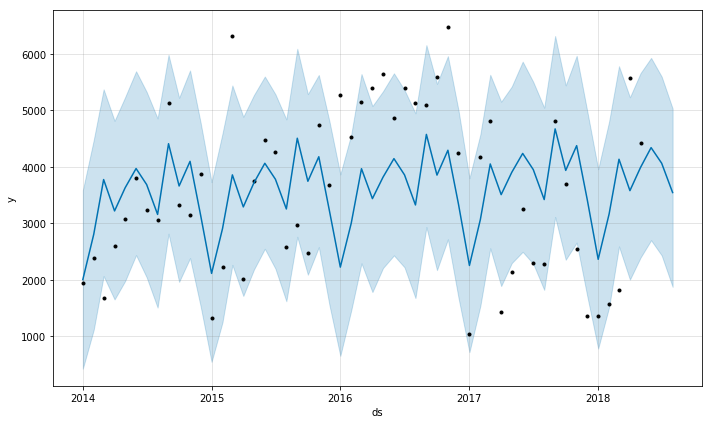

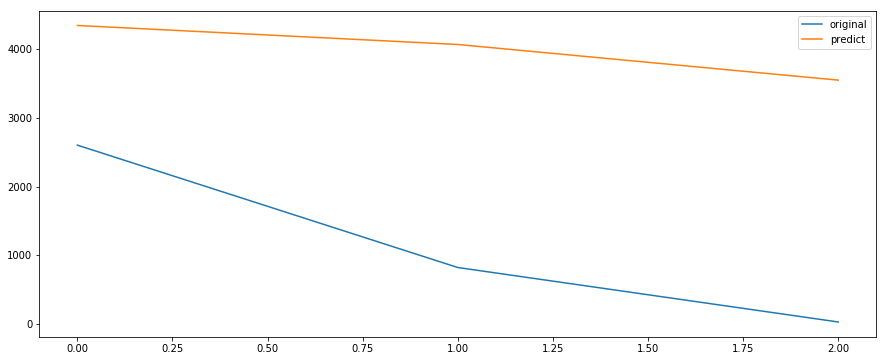

In [157]:
prophet_Monthly(tra,tes)  # prophet result

######################
0       51.562900
1      465.598810
2    14368.765432
dtype: float64
average MAPE:  4961.975714307054 %
If MAPE is "Inf", the test data contains 0
######################
0     40.994042
1    139.903739
2    197.254400
dtype: float64
average Symmetric MAPE:  126.0507269255823 %


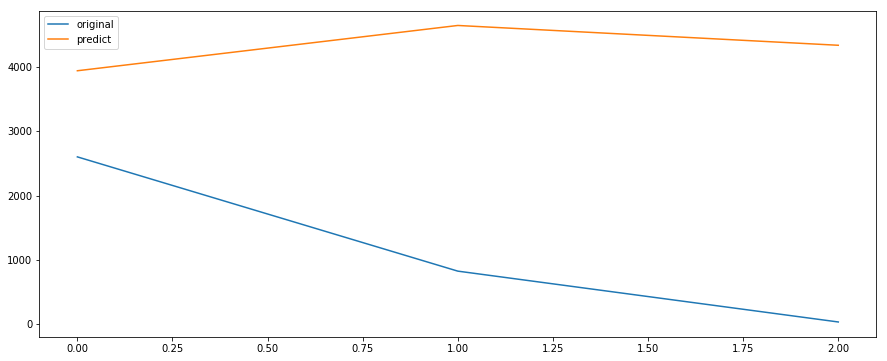

In [158]:
Naive(tra,tes)  # Naive result

In [ ]:
for i in range(3):
    result=check_Monthly(HC_seg,select_Monthly(HC_seg, '2018-05-31', 'Roadie 20', i),'2018-5-31')
    tra,tes = result[0],result[1]
    print ('#################',i,'#############')
    print (arima(10,[0,1,2], tra,tes) )
    print (sarima(3, [0,1,2], range(0,13),tra,tes))
    prophet_Monthly(tra,tes)
    Naive(tra,tes)
    

##### Tundra 75, Class S 

In [248]:
result=check_Weekly(HC_seg, select_Weekly(HC_seg, '2014-03-01','2017-05-31', 'Tundra 75', 0),'2014-03-01','2017-5-31')

In [111]:
result

(Date
 2014-02-24/2014-03-02     14.0
 2014-03-03/2014-03-09     50.0
 2014-03-10/2014-03-16    498.0
 2014-03-17/2014-03-23    587.0
 2014-03-24/2014-03-30    190.0
 2014-03-31/2014-04-06    295.0
 2014-04-07/2014-04-13     94.0
 2014-04-14/2014-04-20    104.0
 2014-04-21/2014-04-27    372.0
 2014-04-28/2014-05-04    224.0
 2014-05-05/2014-05-11    108.0
 2014-05-12/2014-05-18    130.0
 2014-05-19/2014-05-25    182.0
 2014-05-26/2014-06-01    136.0
 2014-06-02/2014-06-08    291.0
 2014-06-09/2014-06-15    239.0
 2014-06-16/2014-06-22    139.0
 2014-06-23/2014-06-29    159.0
 2014-06-30/2014-07-06    140.0
 2014-07-07/2014-07-13    176.0
 2014-07-14/2014-07-20    163.0
 2014-07-21/2014-07-27    157.0
 2014-07-28/2014-08-03    146.0
 2014-08-04/2014-08-10    152.0
 2014-08-11/2014-08-17    118.0
 2014-08-18/2014-08-24    152.0
 2014-08-25/2014-08-31    244.0
 2014-09-01/2014-09-07    128.0
 2014-09-08/2014-09-14    194.0
 2014-09-15/2014-09-21     95.0
                          ...  
 2

In [249]:
tra,tes = result[0],result[1]

In [113]:
tra

Date
2014-02-24/2014-03-02     14.0
2014-03-03/2014-03-09     50.0
2014-03-10/2014-03-16    498.0
2014-03-17/2014-03-23    587.0
2014-03-24/2014-03-30    190.0
2014-03-31/2014-04-06    295.0
2014-04-07/2014-04-13     94.0
2014-04-14/2014-04-20    104.0
2014-04-21/2014-04-27    372.0
2014-04-28/2014-05-04    224.0
2014-05-05/2014-05-11    108.0
2014-05-12/2014-05-18    130.0
2014-05-19/2014-05-25    182.0
2014-05-26/2014-06-01    136.0
2014-06-02/2014-06-08    291.0
2014-06-09/2014-06-15    239.0
2014-06-16/2014-06-22    139.0
2014-06-23/2014-06-29    159.0
2014-06-30/2014-07-06    140.0
2014-07-07/2014-07-13    176.0
2014-07-14/2014-07-20    163.0
2014-07-21/2014-07-27    157.0
2014-07-28/2014-08-03    146.0
2014-08-04/2014-08-10    152.0
2014-08-11/2014-08-17    118.0
2014-08-18/2014-08-24    152.0
2014-08-25/2014-08-31    244.0
2014-09-01/2014-09-07    128.0
2014-09-08/2014-09-14    194.0
2014-09-15/2014-09-21     95.0
                         ...  
2016-11-07/2016-11-13    240.0
201

######################
result of white noice testing (p-value should be small, otherwise: No information in this dataset)
stat                  | p-value
[6.99813813] |
[0.00815945] |
######################


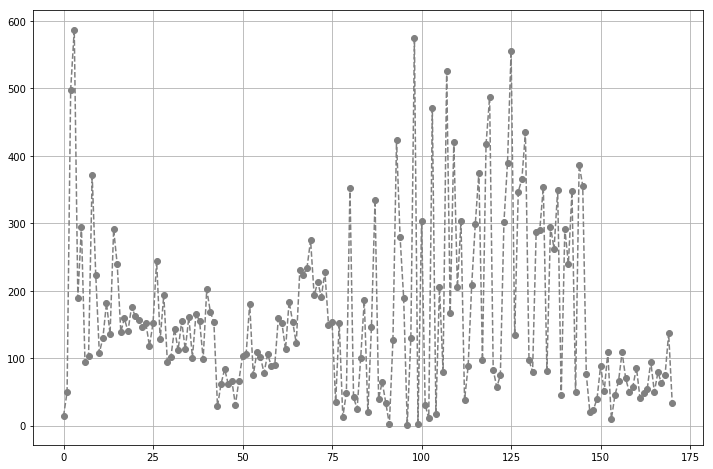

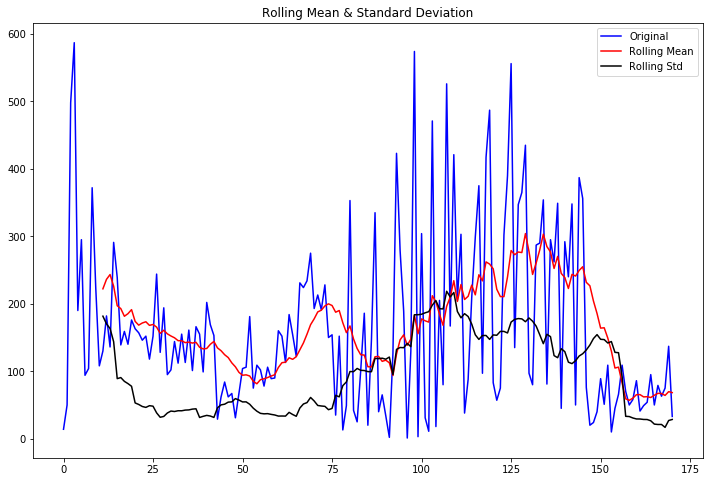

Results of Dickey-Fuller Test:
Test Statistic                  -2.065573
p-value                          0.258581
#Lags Used                       8.000000
Number of Observations Used    162.000000
Critical Value (1%)             -3.471374
Critical Value (5%)             -2.879552
Critical Value (10%)            -2.576373
dtype: float64
######################


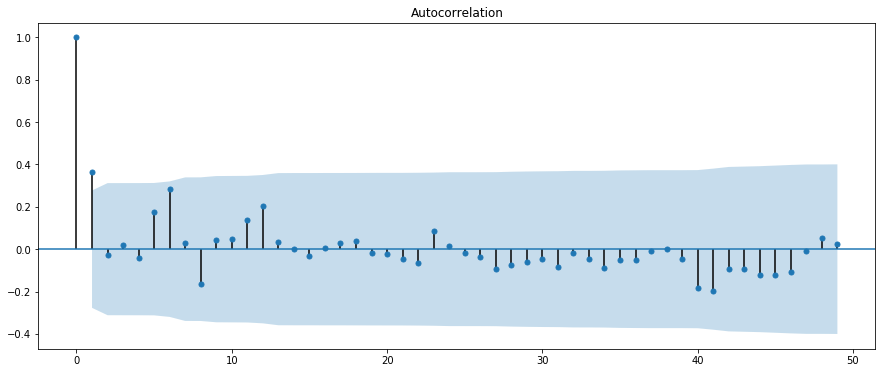

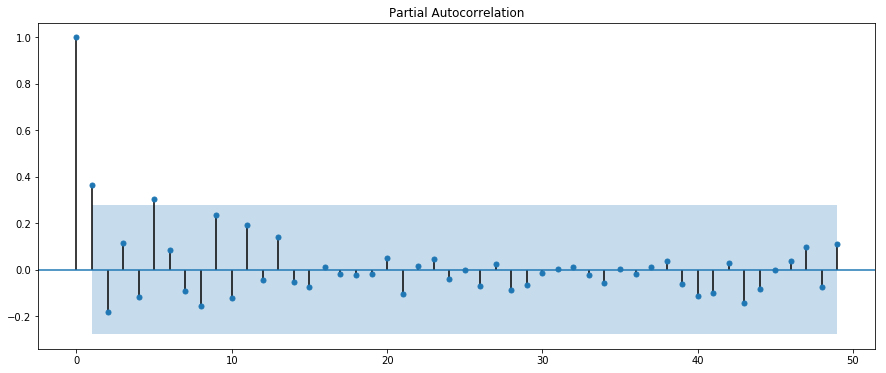

In [250]:
basic_Weekly(tra)

######################
result of white noice testing (p-value should be small, otherwise: No information in this dataset)
stat                  | p-value
[38.06783289] |
[6.83273517e-10] |
######################


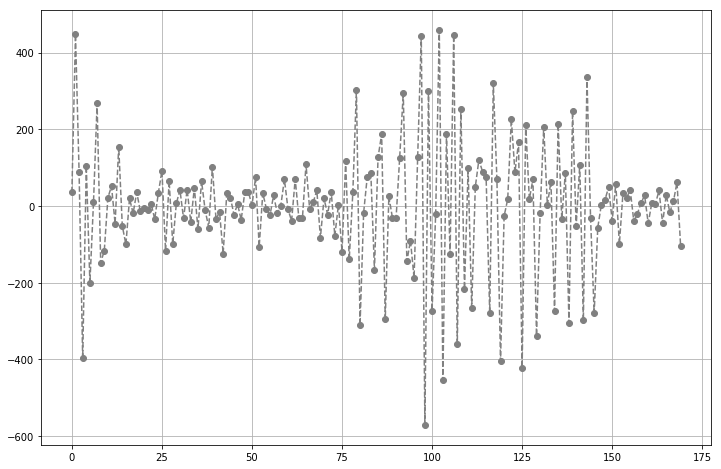

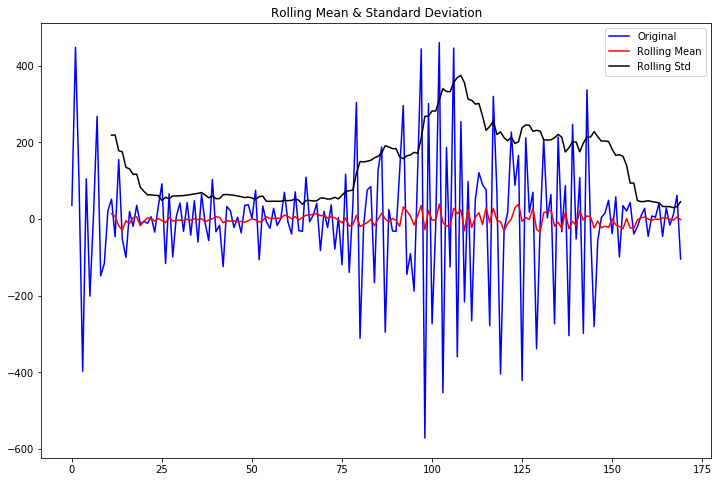

Results of Dickey-Fuller Test:
Test Statistic                -8.185357e+00
p-value                        7.926741e-13
#Lags Used                     7.000000e+00
Number of Observations Used    1.620000e+02
Critical Value (1%)           -3.471374e+00
Critical Value (5%)           -2.879552e+00
Critical Value (10%)          -2.576373e+00
dtype: float64
######################


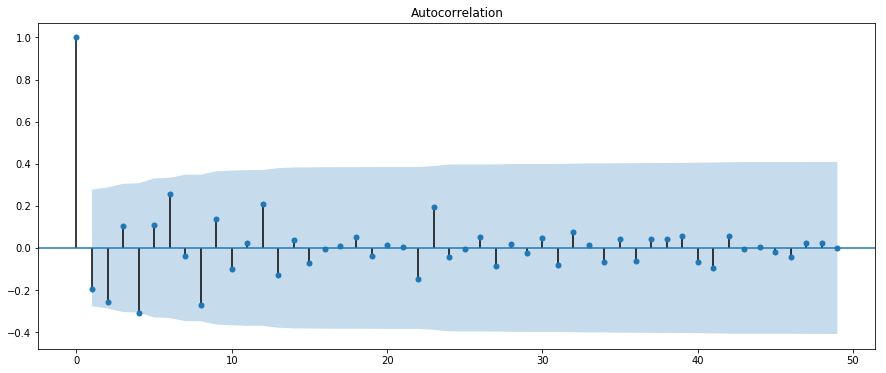

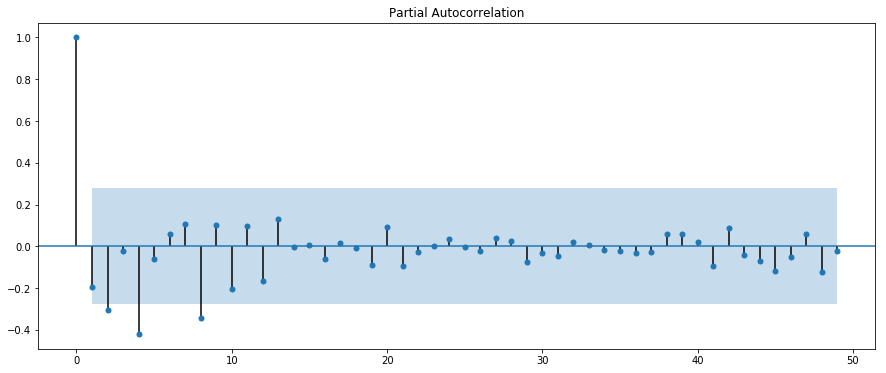

In [251]:
basic_Weekly(tra.diff(1)[1:])

In [258]:
arima(10,[0,1,2], tra,tes)    # ARIMA

(36.06817507527161, 36.06817507527161, (9, 1, 3), (9, 1, 3))

QQ plot of residuals (should be like a straight line)
######################
result of residual's white noice testing (should be very large)
stat                  | p-value
[0.19009164] |
[0.66284036] |
######################
######################
mean squared error:  29.976446330478662
######################
Date
2017-05-29/2017-06-04      43.468596
2017-06-05/2017-06-11      39.363790
2017-06-12/2017-06-18      29.968500
2017-06-19/2017-06-25      28.106364
2017-06-26/2017-07-02      24.742236
2017-07-03/2017-07-09      13.440965
2017-07-10/2017-07-16      25.787638
2017-07-17/2017-07-23      13.437970
2017-07-24/2017-07-30      47.218451
2017-07-31/2017-08-06      26.003092
2017-08-07/2017-08-13      23.628324
2017-08-14/2017-08-20      31.837929
2017-08-21/2017-08-27       2.077890
2017-08-28/2017-09-03      21.145798
2017-09-04/2017-09-10      22.670698
2017-09-11/2017-09-17       9.719368
2017-09-18/2017-09-24      28.283862
2017-09-25/2017-10-01      36.149404
2017-10-02/2017-1

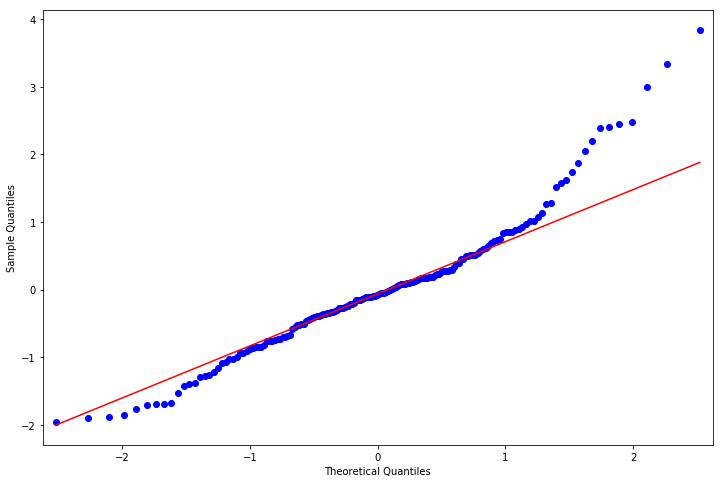

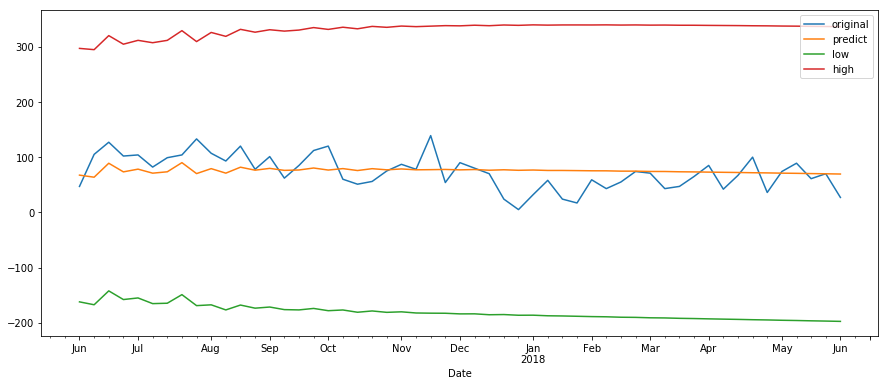

In [175]:
ARIMA_modeling(tra,(9, 1, 3),tes)  #ARIMA result check

In [117]:
sarima(3, [0,1,2], range(0,13),tra,tes)   # SARIMA

          Param Seasonal_param      Smape        mse          AIC          BIC
8682  (2, 0, 1)  (2, 0, 0, 12)  32.688657  27.341601  1810.344677  1829.194658
8466  (1, 0, 2)  (2, 0, 0, 12)  32.804848  27.457145  1822.158834  1841.008815
          Param Seasonal_param      Smape        mse          AIC          BIC
8682  (2, 0, 1)  (2, 0, 0, 12)  32.688657  27.341601  1810.344677  1829.194658
8466  (1, 0, 2)  (2, 0, 0, 12)  32.804848  27.457145  1822.158834  1841.008815
          Param Seasonal_param       Smape         mse          AIC  \
8375  (0, 2, 2)  (0, 2, 2, 12)  615.844190  642.205769  1557.855642   
8618  (1, 2, 2)  (0, 2, 2, 12)  731.034166  632.959413  1559.577898   

              BIC  
8375  1573.563960  
8618  1578.427879  
          Param Seasonal_param       Smape         mse          AIC  \
8375  (0, 2, 2)  (0, 2, 2, 12)  615.844190  642.205769  1557.855642   
8618  (1, 2, 2)  (0, 2, 2, 12)  731.034166  632.959413  1559.577898   

              BIC  
8375  1573.563960 

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                  171
Model:             SARIMAX(2, 0, 1)x(2, 0, 0, 12)   Log Likelihood                -899.172
Date:                            Thu, 09 Aug 2018   AIC                           1810.345
Time:                                    14:59:48   BIC                           1829.195
Sample:                                         0   HQIC                          1817.993
                                            - 171                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9318      0.089     10.412      0.000       0.756       1.107
ar.L2          0.0619      0.086   

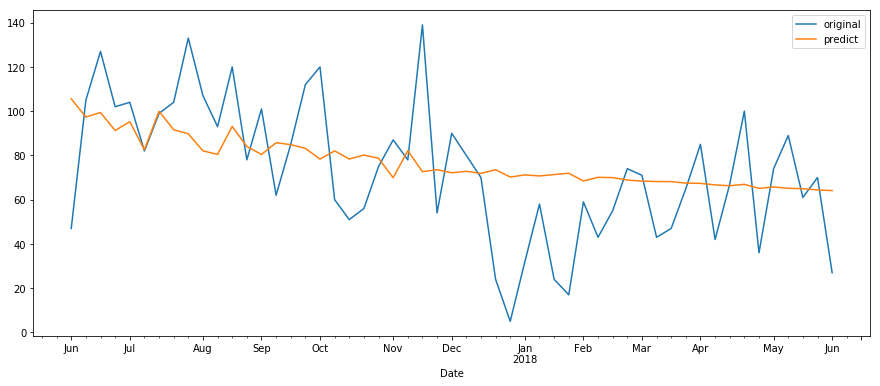

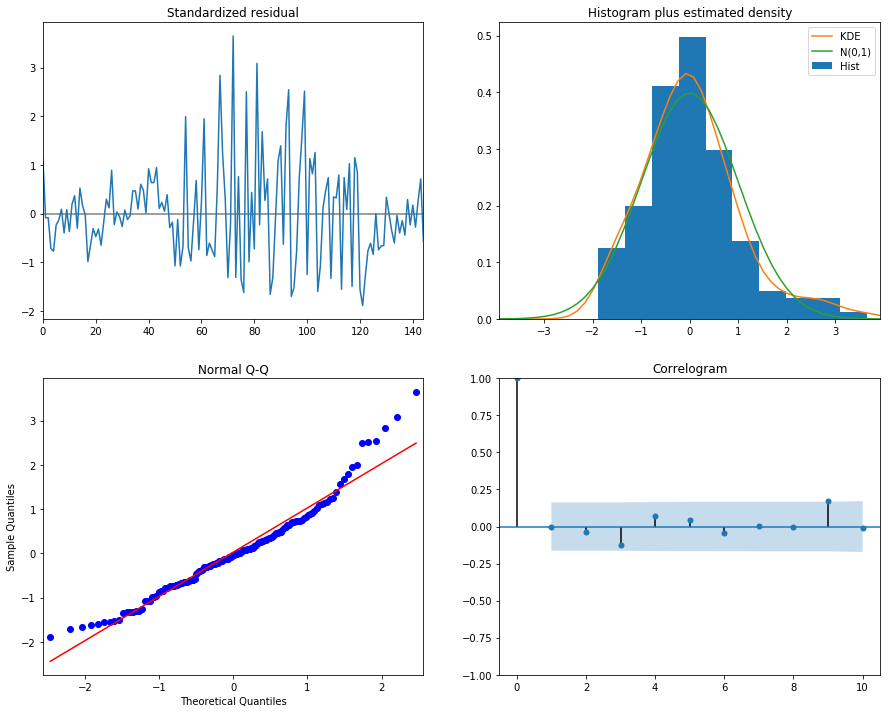

######################
Date
2017-05-29/2017-06-04     124.596710
2017-06-05/2017-06-11       7.262002
2017-06-12/2017-06-18      21.745945
2017-06-19/2017-06-25      10.535702
2017-06-26/2017-07-02       8.407688
2017-07-03/2017-07-09       0.699937
2017-07-10/2017-07-16       0.954069
2017-07-17/2017-07-23      11.912163
2017-07-24/2017-07-30      32.513290
2017-07-31/2017-08-06      23.294663
2017-08-07/2017-08-13      13.506606
2017-08-14/2017-08-20      22.410437
2017-08-21/2017-08-27       7.727642
2017-08-28/2017-09-03      20.348802
2017-09-04/2017-09-10      38.291669
2017-09-11/2017-09-17       0.145359
2017-09-18/2017-09-24      25.723910
2017-09-25/2017-10-01      34.735806
2017-10-02/2017-10-08      36.770785
2017-10-09/2017-10-15      53.693245
2017-10-16/2017-10-22      43.135119
2017-10-23/2017-10-29       4.965950
2017-10-30/2017-11-05      19.658475
2017-11-06/2017-11-12       5.313130
2017-11-13/2017-11-19      47.735450
2017-11-20/2017-11-26      36.207894
2017-11-27

In [120]:
SARIMA_modeling(tra,(2, 0, 1) , (2, 0, 0, 12),tes)  #SARIMA result check

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


######################
0      466.170239
1      122.483869
2       37.743573
3       53.123311
4       91.243118
5      215.360326
6      180.834306
7      138.722268
8       56.331194
9       78.019791
10     104.397639
11      52.600145
12     114.897181
13      62.449753
14     189.887886
15     125.220538
16      57.079355
17      22.733907
18     142.209721
19     258.385656
20     292.357076
21     175.393346
22      70.720377
23      40.418738
24       1.727278
25     305.893184
26     191.201284
27     176.078402
28      88.387354
29     215.251891
30    1692.131849
31     321.796623
32     159.289652
33     408.280791
34     421.448247
35      46.290121
36     150.167546
37     124.908410
38      76.967384
39     117.185666
40     372.742615
41     421.814604
42     264.356679
43     111.611192
44     202.221555
45      85.310624
46      59.668307
47     406.005160
48     125.951934
49      66.104303
50     178.870930
51     227.721702
52     897.108664
dtype: float64
average 

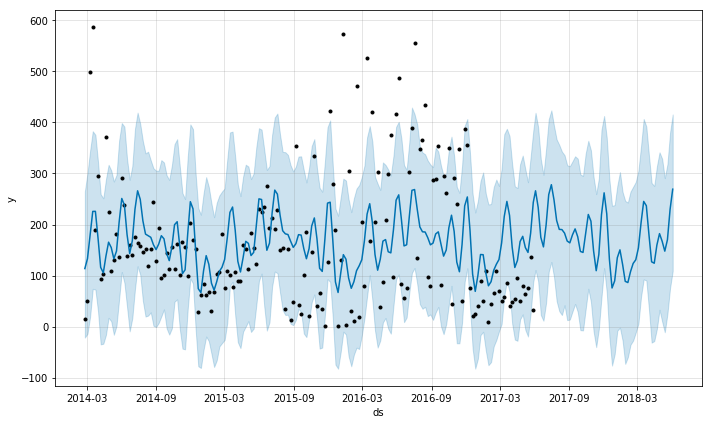

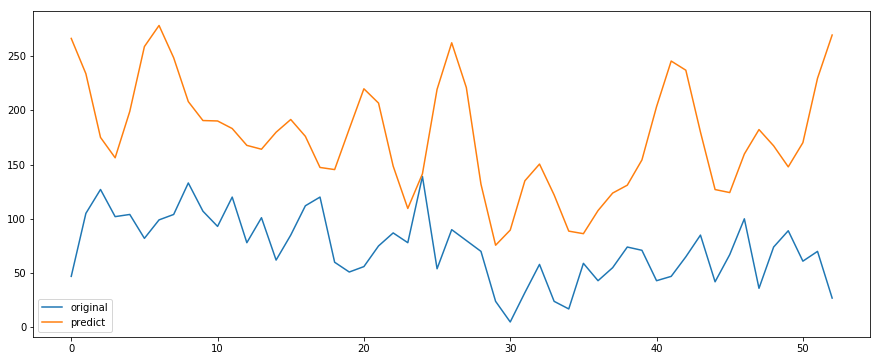

In [121]:
prophet_Weekly(tra,tes)  # prophet result

######################
0      262.946608
1       58.033871
2       25.887988
3       58.164969
4       57.016083
5      101.174027
6       64.017265
7       52.002232
8       13.213865
9       40.998409
10      58.244838
11      19.214713
12      76.345269
13      36.944942
14     124.862359
15      60.741216
16      19.407376
17       7.983618
18     117.494919
19     149.790432
20     122.952442
21      60.832248
22      40.288572
23      52.364710
24      16.144949
25     107.762407
26      25.961253
27      35.252758
28      47.895394
29     333.525621
30    2012.638510
31     234.912970
32      86.964741
33     353.359723
34     546.453053
35      86.294820
36     159.997937
37     105.562679
38      53.982957
39      60.620753
40     167.143470
41     147.012099
42      80.295125
43      38.565125
44     183.878672
45      79.931520
46      21.809857
47     239.765842
48      67.135338
49      39.913676
50     106.039322
51      80.914698
52     368.314156
dtype: float64
average 

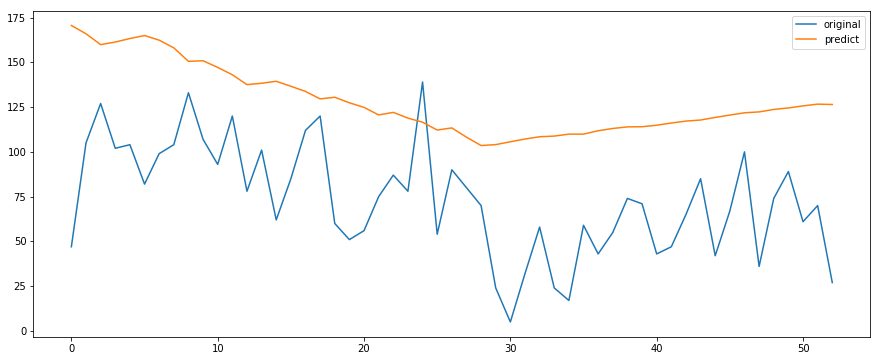

In [122]:
Naive(tra,tes)  # Naive result